In [9]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle

In [10]:
# Function to extract features from audio files
def extract_features_from_directory(data_directory):
    features = []
    labels = []
    for label in os.listdir(data_directory):  # Each subfolder represents a class
        label_path = os.path.join(data_directory, label)
        if os.path.isdir(label_path):  # Ensure it's a folder
            for file in os.listdir(label_path):
                if file.endswith(".wav"):  # Only process .wav files
                    file_path = os.path.join(label_path, file)
                    try:
                        # Load audio file
                        y, sr = librosa.load(file_path, duration=2.5, offset=0.5)
                        
                        # Extract features
                        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

                        # Combine features into a single array
                        feature_vector = np.hstack([
                            np.mean(mfcc.T, axis=0),
                            np.mean(chroma.T, axis=0),
                            np.mean(spectral_contrast.T, axis=0),
                            zero_crossing_rate
                        ])
                        
                        # Append features and labels
                        features.append(feature_vector)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)


In [11]:
# Function to train the model
def train_model(data_directory):
    print("Extracting features from training data...")
    features, labels = extract_features_from_directory(data_directory)

    if len(set(labels)) < 2:
        raise ValueError("The number of classes must be at least 2. Add more data!")

    # Encode labels into numerical format
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

    # Train an SVM model
    print("Training the model...")
    model = SVC(kernel="linear", probability=True)
    model.fit(X_train, y_train)

    # Print training accuracy
    print("Model trained with accuracy:", model.score(X_test, y_test))

    # Save the model and label encoder for later use
    with open("voice_model.pkl", "wb") as model_file:
        pickle.dump(model, model_file)
    with open("label_encoder.pkl", "wb") as encoder_file:
        pickle.dump(label_encoder, encoder_file)

    print("Model and label encoder saved.")


In [12]:
def predict_voice():
    try:
        # Load the saved model and label encoder
        with open("voice_model.pkl", "rb") as model_file:
            model = pickle.load(model_file)
        with open("label_encoder.pkl", "rb") as encoder_file:
            label_encoder = pickle.load(encoder_file)

        # Record or load a test audio file
        file_path = input("Enter the path to the audio file for testing: ")
        y, sr = librosa.load(file_path, duration=2.5, offset=0.5)

        # Extract the same features as used during training
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

        # Combine features into a single array
        feature_vector = np.hstack([
            np.mean(mfcc.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(spectral_contrast.T, axis=0),
            zero_crossing_rate
        ])

        # Predict the class of the audio
        prediction = model.predict([feature_vector])
        predicted_label = label_encoder.inverse_transform(prediction)

        # Display the result
        if predicted_label[0] in ["rahul", "margaret", "jens"]:
            print(f"Welcome {predicted_label[0].capitalize()}!")
        else:
            print("Voice not recognized.")

    except Exception as e:
        print(f"Error during prediction: {e}")


In [13]:
# Main program
def main():
    print("Voice Recognition Program")
    print("1. Train the model")
    print("2. Test the model")
    choice = int(input("Enter your choice (1 or 2): "))

    if choice == 1:
        data_directory = input("Enter the path to the training data directory: ")
        train_model(data_directory)
    elif choice == 2:
        predict_voice()
    else:
        print("Invalid choice. Please enter 1 or 2.")

In [15]:
if __name__ == "__main__":
    main()

Voice Recognition Program
1. Train the model
2. Test the model
Welcome Margaret!


In [10]:
import os
import librosa
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
def extract_features_from_directory(data_directory):
    features = []
    labels = []
    raw_audio_samples = {}
    for label in os.listdir(data_directory):  # Each subfolder represents a class
        label_path = os.path.join(data_directory, label)
        if os.path.isdir(label_path):  # Ensure it's a folder
            for file in os.listdir(label_path):
                if file.endswith(".wav"):  # Only process .wav files
                    file_path = os.path.join(label_path, file)
                    try:
                        # Load audio file
                        y, sr = librosa.load(file_path, duration=2.5, offset=0.5)

                        # Extract features
                        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

                        # Combine features into a single array
                        feature_vector = np.hstack([
                            np.mean(mfcc.T, axis=0),
                            np.mean(chroma.T, axis=0),
                            np.mean(spectral_contrast.T, axis=0),
                            zero_crossing_rate
                        ])

                        # Append features and labels
                        features.append(feature_vector)
                        labels.append(label)

                        # Store raw audio samples for visualization
                        if label not in raw_audio_samples:
                            raw_audio_samples[label] = y  # Keep one sample per label
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels), raw_audio_samples

In [12]:
def plot_metrics(model, X_test, y_test, label_encoder, raw_audio_samples):
    # Calculate predictions
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot raw audio samples for each class
    plt.figure(figsize=(12, 8))
    for i, (label, audio) in enumerate(raw_audio_samples.items()):
        plt.subplot(len(raw_audio_samples), 1, i + 1)
        plt.plot(audio)
        plt.title(f"Sample Audio Waveform - {label.capitalize()}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

In [13]:
def train_model(data_directory):
    print("Extracting features from training data...")
    features, labels, raw_audio_samples = extract_features_from_directory(data_directory)

    if len(set(labels)) < 2:
        raise ValueError("The number of classes must be at least 2. Add more data!")

    # Encode labels into numerical format
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

    # Train an SVM model
    print("Training the model...")
    model = SVC(kernel="linear", probability=True)
    model.fit(X_train, y_train)

    # Print training accuracy
    accuracy = model.score(X_test, y_test)
    print("Model trained with accuracy:", accuracy)

    # Plot confusion matrix, metrics, and raw audio samples
    plot_metrics(model, X_test, y_test, label_encoder, raw_audio_samples)

    # Save the model and label encoder for later use
    with open("voice_model.pkl", "wb") as model_file:
        pickle.dump(model, model_file)
    with open("label_encoder.pkl", "wb") as encoder_file:
        pickle.dump(label_encoder, encoder_file)

    print("Model and label encoder saved.")


In [14]:


def predict_voice():
    try:
        # Load the saved model and label encoder
        with open("voice_model.pkl", "rb") as model_file:
            model = pickle.load(model_file)
        with open("label_encoder.pkl", "rb") as encoder_file:
            label_encoder = pickle.load(encoder_file)

        # Record or load a test audio file
        file_path = input("Enter the path to the audio file for testing: ")
        y, sr = librosa.load(file_path, duration=2.5, offset=0.5)

        # Plot the waveform of the audio
        plt.figure(figsize=(10, 4))
        plt.plot(y)
        plt.title("Waveform of the Selected Audio File")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()

        # Extract the same features as used during training
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

        # Combine features into a single array
        feature_vector = np.hstack([
            np.mean(mfcc.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(spectral_contrast.T, axis=0),
            zero_crossing_rate
        ])

        # Predict the class of the audio
        prediction = model.predict([feature_vector])
        predicted_label = label_encoder.inverse_transform(prediction)

        # Display the result
        if predicted_label[0] in ["rahul", "margaret", "jens"]:
            print(f"Welcome {predicted_label[0].capitalize()}!")
        else:
            print("Voice not recognized.")

    except Exception as e:
        print(f"Error during prediction: {e}")



Voice Recognition Program
1. Train the model
2. Test the model
Extracting features from training data...
Training the model...
Model trained with accuracy: 0.8125


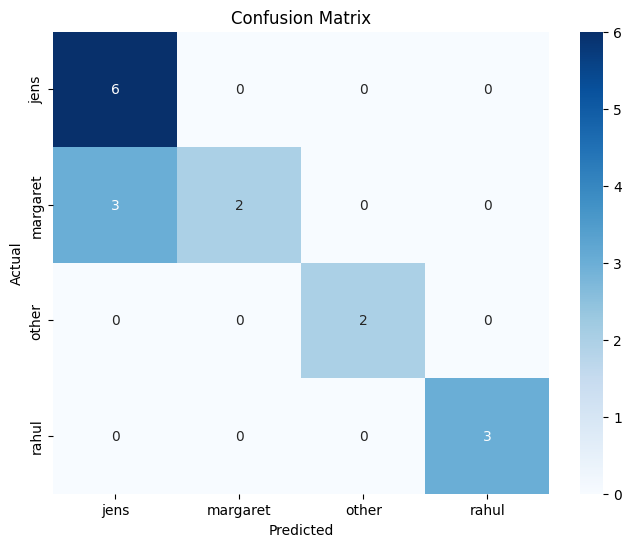

Classification Report:

              precision    recall  f1-score   support

        jens       0.67      1.00      0.80         6
    margaret       1.00      0.40      0.57         5
       other       1.00      1.00      1.00         2
       rahul       1.00      1.00      1.00         3

    accuracy                           0.81        16
   macro avg       0.92      0.85      0.84        16
weighted avg       0.88      0.81      0.79        16



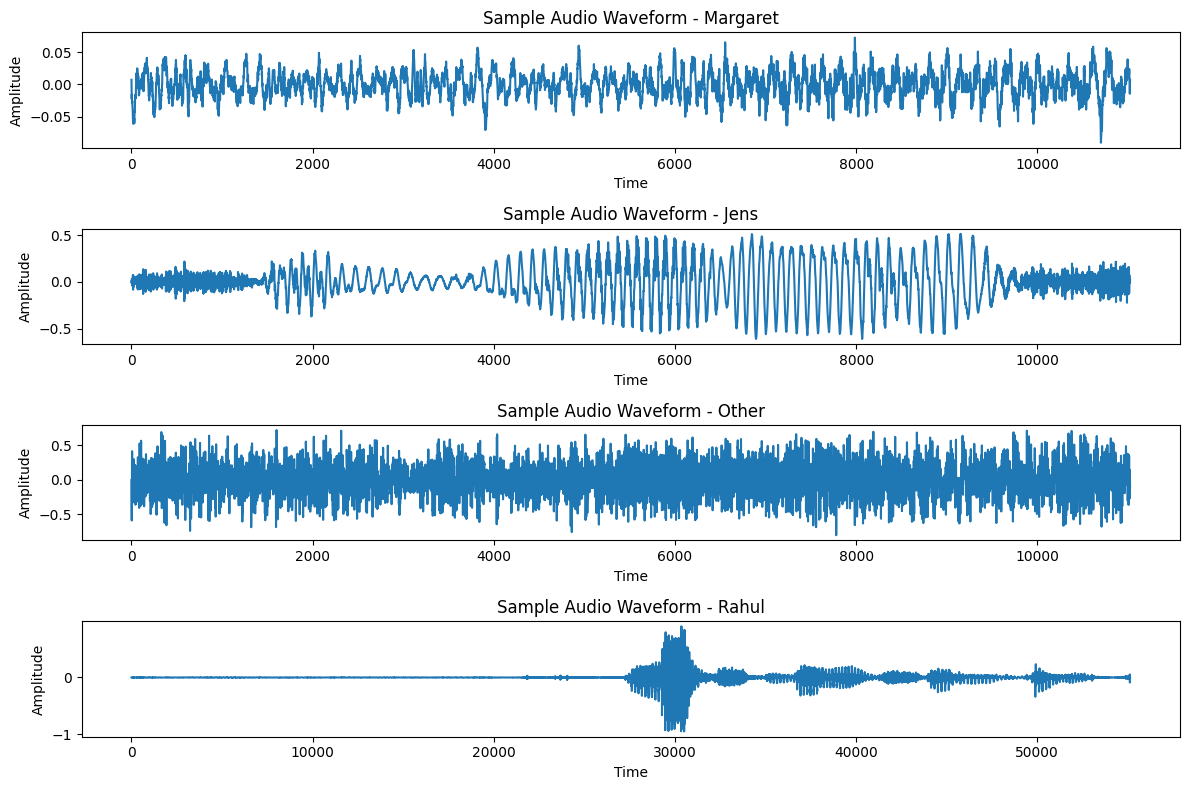

Model and label encoder saved.


In [15]:
# Main program
def main():
    print("Voice Recognition Program")
    print("1. Train the model")
    print("2. Test the model")
    choice = int(input("Enter your choice (1 or 2): "))

    if choice == 1:
        data_directory = input("Enter the path to the training data directory: ")
        train_model(data_directory)
    elif choice == 2:
        predict_voice()
    else:
        print("Invalid choice. Please enter 1 or 2.")

if __name__ == "__main__":
    main()

Voice Recognition Program
1. Train the model
2. Test the model


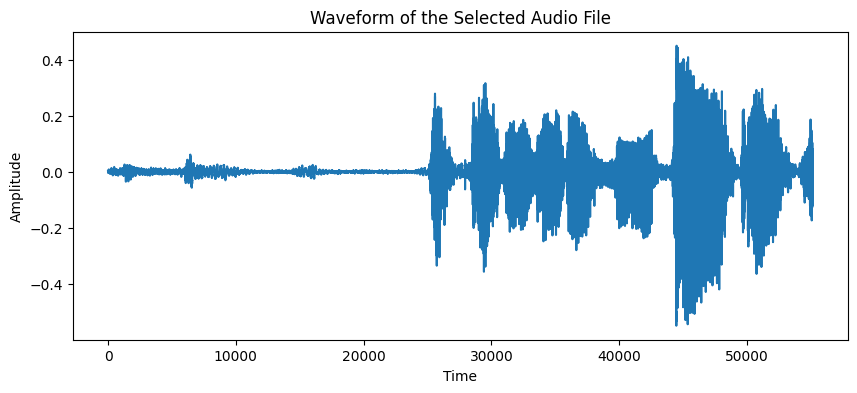

Welcome Rahul!


In [16]:
# Main program
def main():
    print("Voice Recognition Program")
    print("1. Train the model")
    print("2. Test the model")
    choice = int(input("Enter your choice (1 or 2): "))

    if choice == 1:
        data_directory = input("Enter the path to the training data directory: ")
        train_model(data_directory)
    elif choice == 2:
        predict_voice()
    else:
        print("Invalid choice. Please enter 1 or 2.")

if __name__ == "__main__":
    main()